## Chroma multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` (Shown) 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook highlights `Option 1`: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use Open Clip multi-modal embeddings.
* We will use [Chroma](https://www.trychroma.com/) with support for multi-modal.

A separate cookbook highlights `Options 2 and 3` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb).

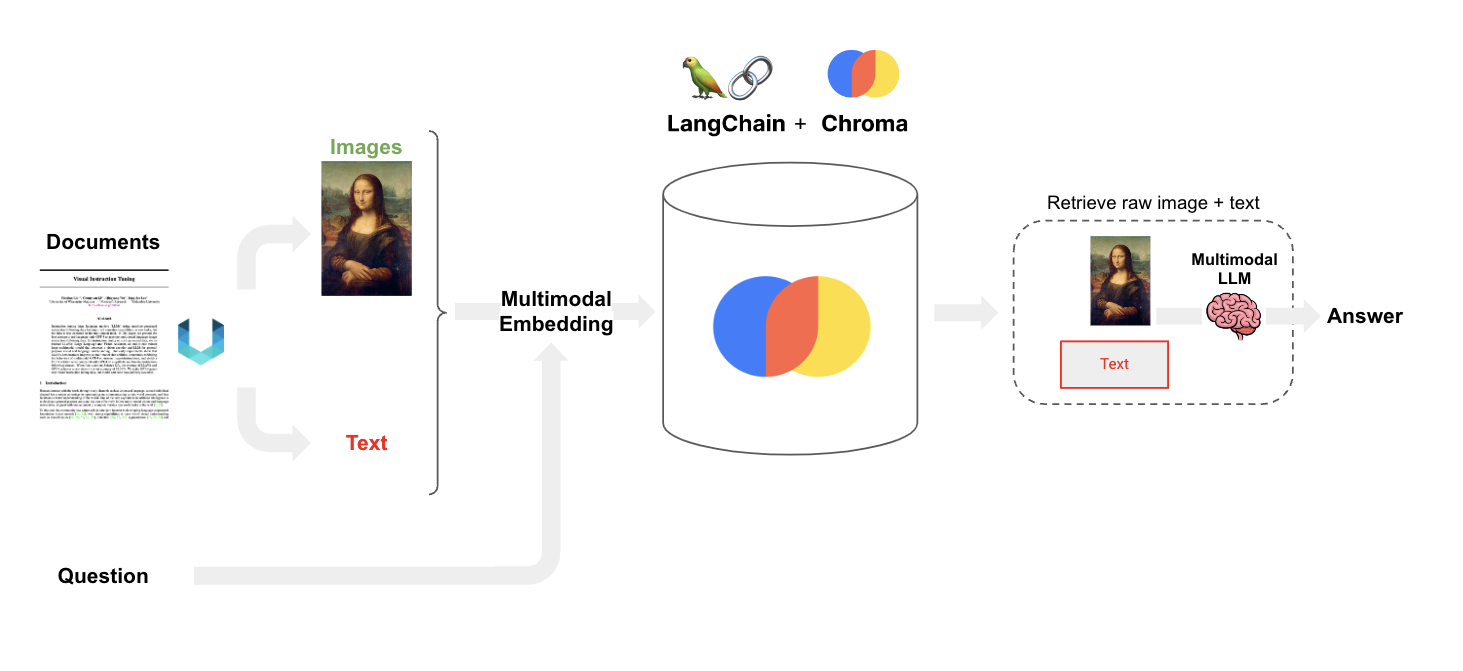

## Packages

For `unstructured`, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)

In [ ]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

## Data Loading

### Partition PDF text and images
  
Let's look at an example pdfs containing interesting images.

1/ Art from the J Paul Getty museum:

 * Here is a [zip file](https://drive.google.com/file/d/18kRKbq2dqAhhJ3DfZRnYcTBEUfYxe1YR/view?usp=sharing) with the PDF and the already extracted images. 
* https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf

2/ Famous photographs from library of congress:

* https://www.loc.gov/lcm/pdf/LCM_2020_1112.pdf
* We'll use this as an example below

We can use `partition_pdf` below from [Unstructured](https://unstructured-io.github.io/unstructured/introduction.html#key-concepts) to extract text and images.

To supply this to extract the images:
```
extract_images_in_pdf=True
```



If using this zip file, then you can simply process the text only with:
```
extract_images_in_pdf=False
```

In [8]:
# Folder with pdf and extracted images
path = "/Users/rlm/Desktop/photos/"

In [9]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=path + "photos.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [10]:
# Categorize text elements by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings with our document

We will use [OpenClip multimodal embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

We use a larger model for better performance (set in `langchain_experimental.open_clip.py`).

```
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
```

In [11]:
import os
import uuid

import chromadb
import numpy as np
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image as _PILImage

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever()

## RAG

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

These can be passed to [GPT-4V](https://platform.openai.com/docs/guides/vision).

In [70]:
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [75]:
from operator import itemgetter

from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]


model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

## Test retrieval and run RAG

GREAT PHOTOGRAPHS
The subject of the photo, Florence Owens Thompson, a Cherokee from Oklahoma, initially regretted that Lange ever made this photograph. “She was a very strong woman. She was a leader,” her daughter Katherine later said. “I think that's one of the reasons she resented the photo — because it didn't show her in that light.”

DOROTHEA LANGE. “DESTITUTE PEA PICKERS IN CALIFORNIA. MOTHER OF SEVEN CHILDREN. AGE THIRTY-TWO. NIPOMO, CALIFORNIA.” MARCH 1936. NITRATE NEGATIVE. FARM SECURITY ADMINISTRATION-OFFICE OF WAR INFORMATION COLLECTION. PRINTS AND PHOTOGRAPHS DIVISION.

—Helena Zinkham

—Helena Zinkham

NOVEMBER/DECEMBER 2020 LOC.GOV/LCM



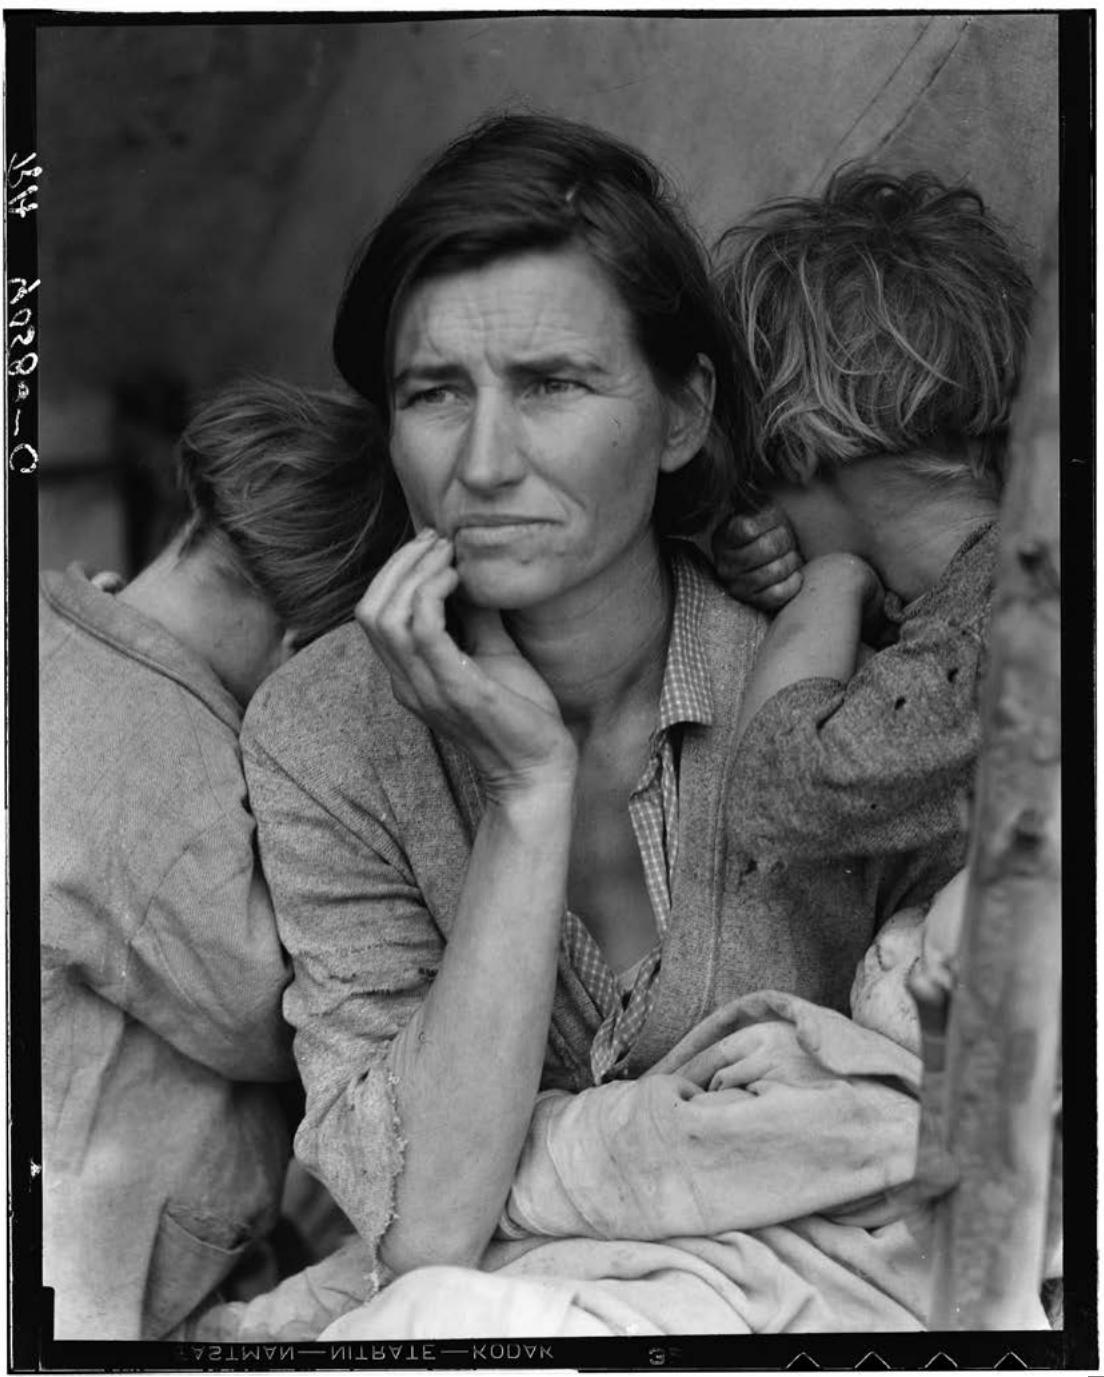

THEYRE WILLING TO HAVE MEENTERTAIN THEM DURING THE DAY,BUT AS SOON AS IT STARTSGETTING DARK, THEY ALLGO OFF, AND LEAVE ME!


In [76]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


docs = retriever.get_relevant_documents("Woman with children", k=10)
for doc in docs:
    if is_base64(doc.page_content):
        plt_img_base64(doc.page_content)
    else:
        print(doc.page_content)

In [77]:
chain.invoke("Woman with children")

'Visual Elements:\nThe image is a black and white photograph depicting a woman with two children. The woman is positioned centrally and appears to be in her thirties. She has a look of concern or contemplation on her face, with her hand resting on her chin. Her gaze is directed away from the camera, suggesting introspection or worry. The children are turned away from the camera, with their heads leaning against the woman, seeking comfort or protection. The clothing of the subjects is simple and worn, indicating a lack of wealth. The background is out of focus, drawing attention to the expressions and posture of the subjects.\n\nHistorical and Cultural Context:\nThe photograph was taken by Dorothea Lange in March 1936 and is titled "Destitute pea pickers in California. Mother of seven children. Age thirty-two. Nipomo, California." It was taken during the Great Depression in the United States, a period of severe economic hardship. The woman in the photo, Florence Owens Thompson, was a Ch

We can see the images retrieved in the LangSmith trace:

LangSmith [trace](https://smith.langchain.com/public/69c558a5-49dc-4c60-a49b-3adbb70f74c5/r/e872c2c8-528c-468f-aefd-8b5cd730a673).